<a href="https://colab.research.google.com/github/dionysiadimi/matzaris/blob/main/scRNAseq_analysis_of_BCa_samples_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import scipy

In [4]:
!pip install leidenalg

In [5]:
!pip install louvain scanpy

In [6]:
!pip install kb-python

In [7]:
!wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_fastqs.tar

--2023-08-19 21:18:33--  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_fastqs.tar
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5278996480 (4.9G) [application/x-tar]
Saving to: ‘Visium_FFPE_Human_Breast_Cancer_fastqs.tar.4’

Visium_FFPE_Human_B 100%[===================>]   4.92G   174MB/s    in 45s     

2023-08-19 21:19:19 (111 MB/s) - ‘Visium_FFPE_Human_Breast_Cancer_fastqs.tar.4’ saved [5278996480/5278996480]



In [8]:
!tar xf Visium_FFPE_Human_Breast_Cancer_fastqs.tar

In [11]:
#Download the human index

In [9]:
!kb ref -d human -i index.idx -g t2g.txt -f1 trascriptome.fasta

[2023-08-19 21:20:43,840]    INFO [download] Skipping download because some files already exist. Use the --overwrite flag to overwrite.


In [10]:
!kb count --h5ad -i index.idx -g t2g.txt -x 10xv1 -o output --filter bustools -t 2 \
Visium_FFPE_Human_Breast_Cancer_fastqs.tar

[2023-08-19 21:21:02,586]    INFO [count] Using index index.idx to generate BUS file to output from
[2023-08-19 21:21:02,587]    INFO [count]         Visium_FFPE_Human_Breast_Cancer_fastqs.tar
[2023-08-19 21:21:03,600]   ERROR [count] kallisto 0.48.0
Generates BUS files for single-cell sequencing

Usage: kallisto bus [arguments] FASTQ-files

Required arguments:
-i, --index=STRING            Filename for the kallisto index to be used for
pseudoalignment
-o, --output-dir=STRING       Directory to write output to

Optional arguments:
-x, --technology=STRING       Single-cell technology used
-l, --list                    List all single-cell technologies supported
-B, --batch=FILE              Process files listed in FILE
-t, --threads=INT             Number of threads to use (default: 1)
-b, --bam                     Input file is a BAM file
-n, --num                     Output number of read in flag column (incompatible with --bam)
-T, --tag=STRING              5′ tag sequence to identif

In [11]:
import scanpy as sc
import anndata



In [12]:
from sklearn.decomposition import TruncatedSVD

In [13]:
import matplotlib

In [14]:
sc.settings.verbosity=3

sc.settings.set_figure_params(dpi=80)


In [15]:
!wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.tar.gz
!wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.h5

--2023-08-19 21:21:33--  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58271640 (56M) [application/x-tar]
Saving to: ‘Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.tar.gz.4’

Visium_FFPE_Human_B 100%[===================>]  55.57M   177MB/s    in 0.3s    

2023-08-19 21:21:34 (177 MB/s) - ‘Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.tar.gz.4’ saved [58271640/58271640]

--2023-08-19 21:21:34--  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:

In [16]:
#load the unfiltered data

results_file= 'data.h5ad'
adata=sc.read_10x_h5("Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.h5")
adata.var["gene_id"] =adata.var.index.values

reading Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.h5
 (0:00:01)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [17]:
t2g=pd.read_csv("t2g.txt", header=None, names=["tid","gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g=t2g.loc[~t2g.index.duplicated(keep='first')]

In [18]:
adata.var['gene_name']=adata.var.gene_id.map(t2g["gene_name"])
adata.var.index=adata.var

In [19]:
adata.var_names_make_unique()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:887: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [('ENSG00000243485', 'Gene Expression', 'GRCh38', 'MIR1302-2HG', nan), ('ENSG00000237613', 'Gene Expression', 'GRCh38', 'FAM138A', nan), ('ENSG00000186092', 'Gene Expression', 'GRCh38', 'OR4F5', nan), ('ENSG00000238009', 'Gene Expression', 'GRCh38', 'AL627309.1', nan), ('ENSG00000239945', 'Gene Expression', 'GRCh38', 'AL627309.3', nan)]

    Inferred to be: mixed

  names = self._prep_dim_index(names, "var")


In [20]:
adata

AnnData object with n_obs × n_vars = 4992 × 36945
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id', 'gene_name'

In [21]:
# We need to test for library saturation

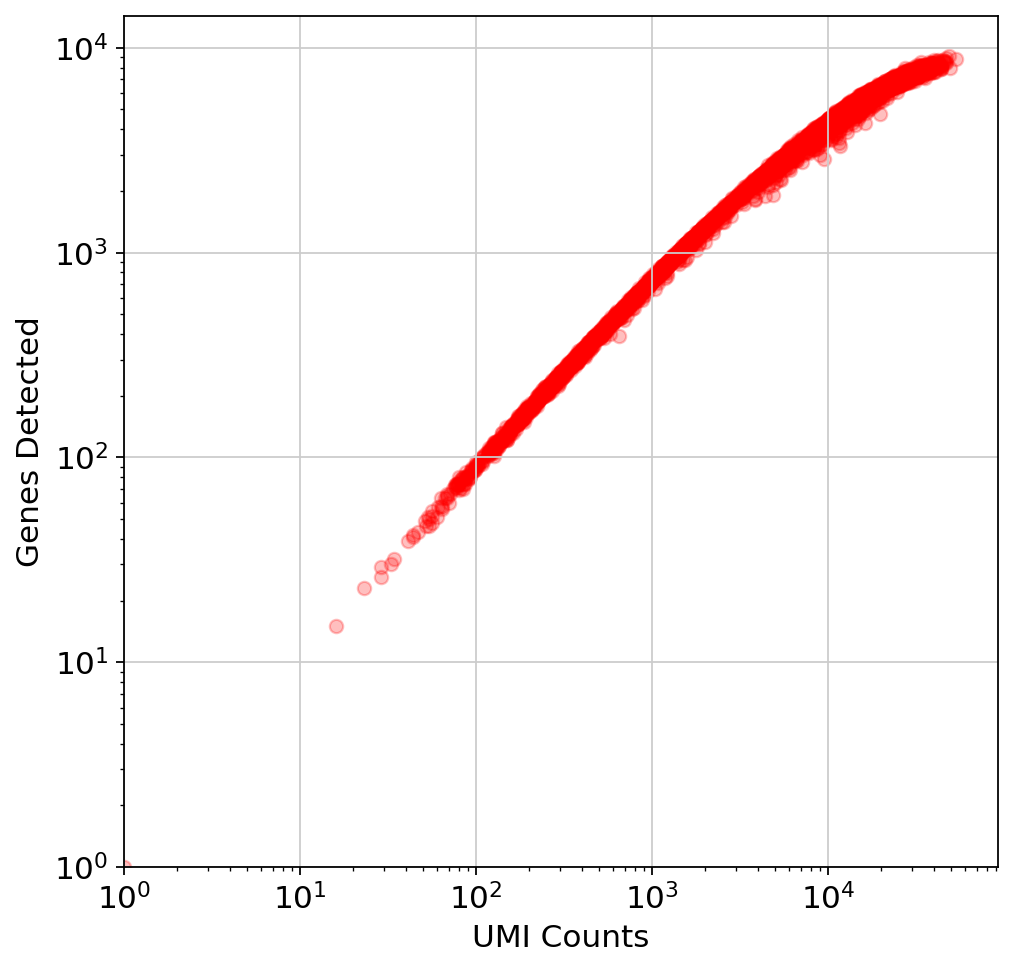

In [22]:
fig, ax=plt.subplots(figsize=(7,7))
x=np.asarray(adata.X.sum(axis=1))[:,0]
y=np.asarray(np.sum(adata.X>0, axis=1))[:,0]
ax.scatter(x,y, color="red", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1)
ax.set_ylim(1)
plt.show()

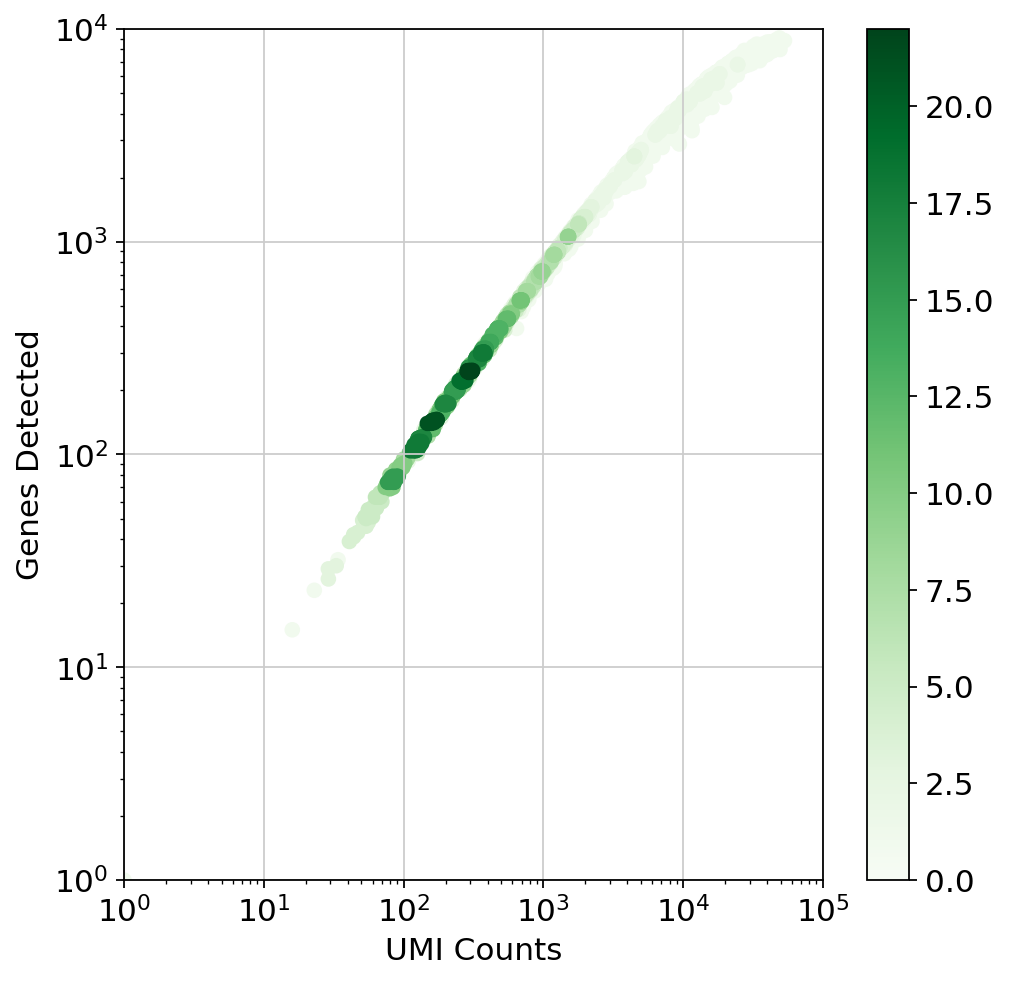

In [23]:
fig, ax=plt.subplots(figsize=(7,7))
bins=[1500, 1500]
hh, locx, locy=np.histogram2d(x,y, bins=bins)
z=np.array([hh[np.argmax(a<=locx[1:]), np.argmax(b<=locy[1:])]for a,b in zip(x,y)])
idx=z.argsort()
x2,y2,z2=x[idx], y[idx], z[idx]

s=ax.scatter(x2,y2, c=z2, cmap="Greens")
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)
plt.show()

In [27]:
#The abovementioned step was to sort the points by density

In [28]:
#The next step is to examine the knee plot

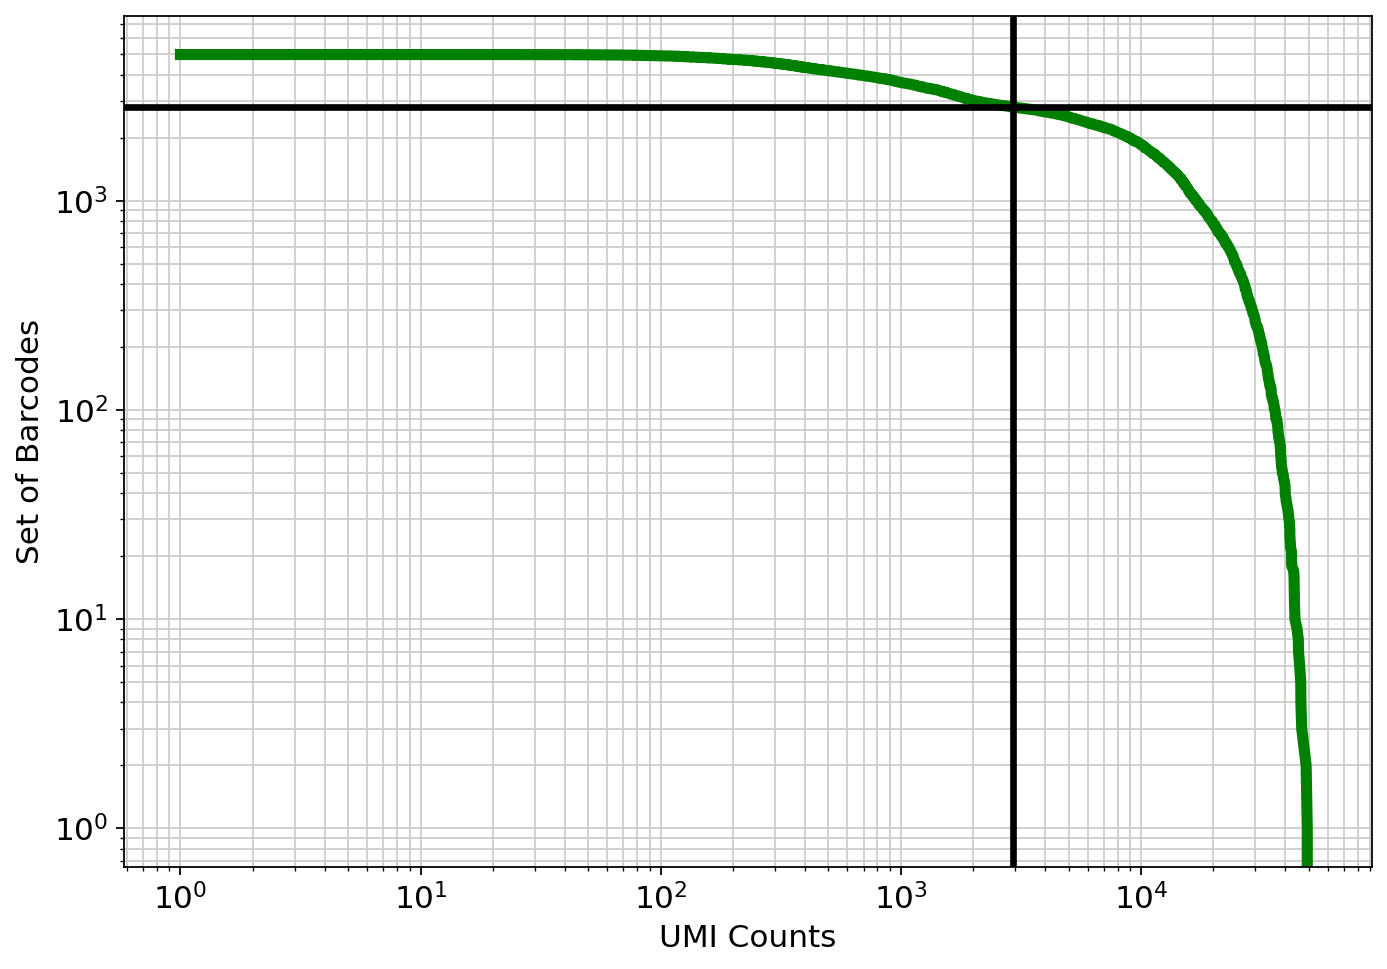

In [24]:
expected_num_cells=2800#@param{type:"integer"}
knee=np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
fig, ax=plt.subplots(figsize=(10,7))
ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")
plt.grid(True, which="both")
plt.show()

In [30]:
#ANALYSIS
#EXAMINE mt genes

normalizing counts per cell
    finished (0:00:00)


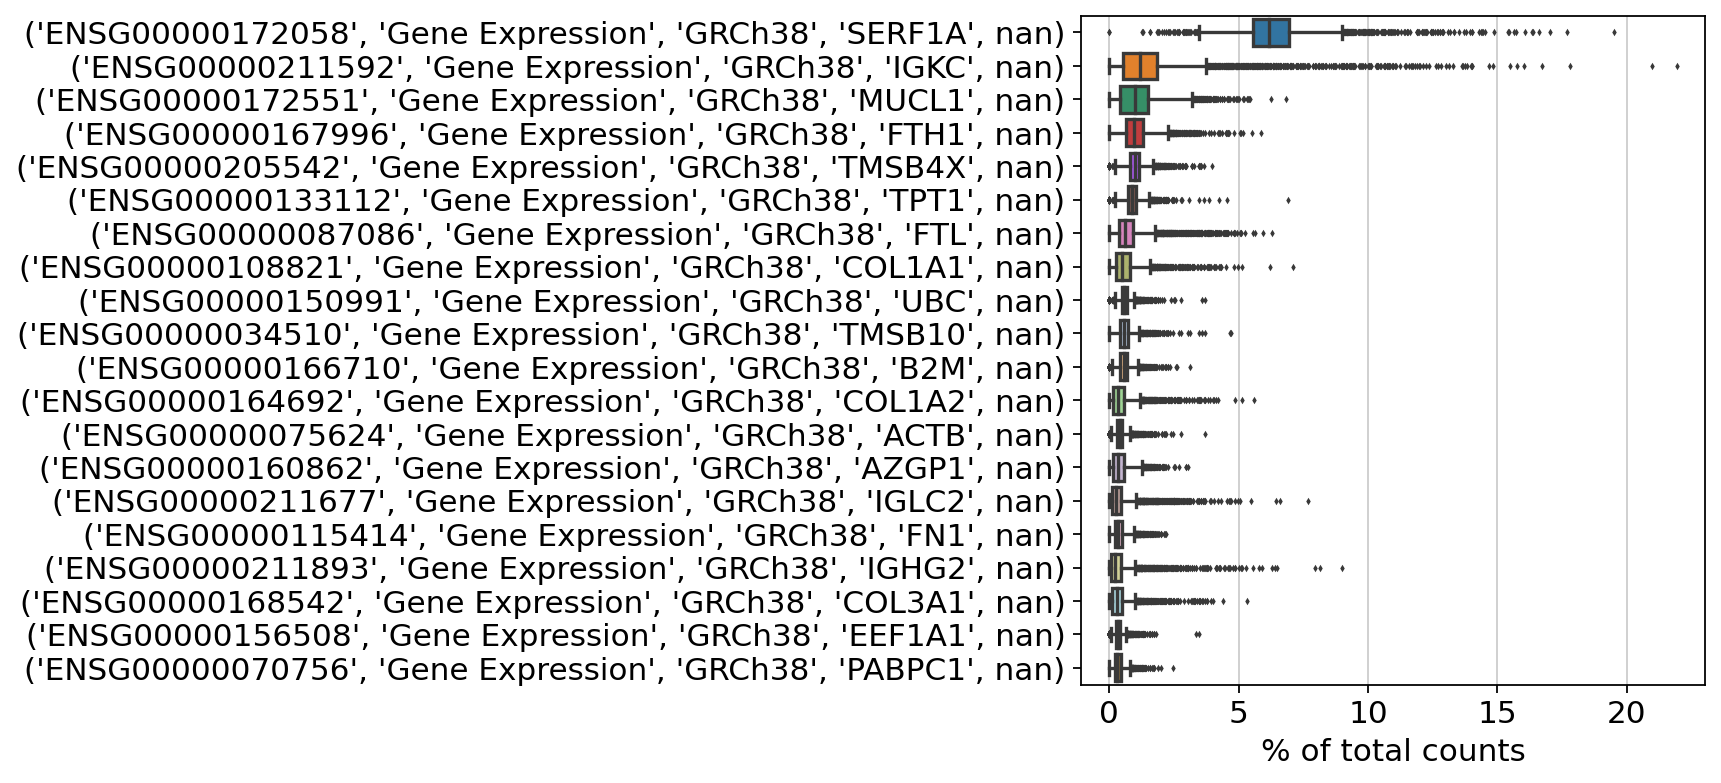

In [25]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [32]:
#NOW WE NEED TO FILTER
#WE need to remove cells with less than 1070 counts

In [26]:
adata=adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) > 1070]

#We need tp remove genes with 0 counts
adata=adata[:, np.asarray(adata.X.sum(axis=0)). reshape(-1) >0]

In [27]:
adata

View of AnnData object with n_obs × n_vars = 3622 × 19172
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id', 'gene_name'

In [28]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


filtered out 858 genes that are detected in less than 3 cells


In [29]:
adata

AnnData object with n_obs × n_vars = 3622 × 18314
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id', 'gene_name', 'n_cells'

In [37]:
#We need to filter for mt gene content -->needs improvement code wrong!

In [30]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))




In [32]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

IndexError: ignored